# Linear Regression Overview

Linear regression is a basic supervised learning technique for estimating a continuous target variable from one or more input features. Its hypothesis function is

$$
h_{w,b}(x) = w\,x + b
$$

where  
- \(h_{w,b}(x)\) is the predicted value for input \(x\),  
- \(w\) is the weight (slope),  
- \(b\) is the bias (intercept).

## Training Objective

We want to find \((w, b)\) that minimize the discrepancy between predictions and true labels.

### Prediction

For each example \(x^{(i)}\), the model predicts

$$
\hat y^{(i)} = h_{w,b}\bigl(x^{(i)}\bigr) = w\,x^{(i)} + b.
$$

### Loss Function

We measure error using the Mean Squared Error:

$$
L(w,b) = \frac{1}{2m} \sum_{i=1}^{m} \bigl(\hat y^{(i)} - y^{(i)}\bigr)^{2}
$$

where  
- \(m\) is the number of training examples,  
- \(y^{(i)}\) is the true target for the \(i\)-th sample.

### Gradient Computation

Compute partial derivatives of \(L\) with respect to each parameter:

$$
\frac{\partial L}{\partial w}
= \frac{1}{m}\sum_{i=1}^{m} \bigl(\hat y^{(i)} - y^{(i)}\bigr)\,x^{(i)},
$$

$$
\frac{\partial L}{\partial b}
= \frac{1}{m}\sum_{i=1}^{m} \bigl(\hat y^{(i)} - y^{(i)}\bigr).
$$

## Parameter Updates (Gradient Descent)

Update rules using learning rate \(\eta\):

$$
w \;\leftarrow\; w - \eta \,\frac{\partial L}{\partial w},
\qquad
b \;\leftarrow\; b - \eta \,\frac{\partial L}{\partial b}.
$$

By repeating prediction → loss → gradients → update, the model parameters converge to the best fit.


In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlfs.linear_regression import LinearRegression as CustomLinearRegression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression

In [4]:
def generate_data(n_samples, n_features=10, noise=0.1, random_state=42):
    rng = np.random.RandomState(random_state)
    X = rng.randn(n_samples, n_features)
    true_coef = rng.randn(n_features)
    y = X.dot(true_coef) + noise * rng.randn(n_samples)
    return X, y

In [16]:
def benchmark(n_samples_list, n_features=10, n_repeats=3):
    results = []
    for n in n_samples_list:
        X, y = generate_data(n, n_features)
        custom_times = {'fit': [], 'predict': []}
        for _ in range(n_repeats):
            model = CustomLinearRegression()
            t0 = time.perf_counter()
            model.fit(X, y, verbose = False)
            t1 = time.perf_counter()
            model.predict(X[:10])
            t2 = time.perf_counter()
            custom_times['fit'].append(t1 - t0)
            custom_times['predict'].append(t2 - t1)
        sklearn_times = {'fit': [], 'predict': []}
        for _ in range(n_repeats):
            model = SklearnLinearRegression()
            t0 = time.perf_counter()
            model.fit(X, y)
            t1 = time.perf_counter()
            model.predict(X[:10])
            t2 = time.perf_counter()
            sklearn_times['fit'].append(t1 - t0)
            sklearn_times['predict'].append(t2 - t1)
        results.append({
            'n_samples': n,
            'custom_fit': np.mean(custom_times['fit']),
            'custom_predict': np.mean(custom_times['predict']),
            'sklearn_fit': np.mean(sklearn_times['fit']),
            'sklearn_predict': np.mean(sklearn_times['predict']),
        })
    return pd.DataFrame(results)


In [17]:
n_samples_list = [100, 1_000, 5_000, 10_000, 20_000]
df = benchmark(n_samples_list)
df


,n_samples,custom_fit,custom_predict,sklearn_fit,sklearn_predict
0,100,0.026303,0.000012,0.000686,0.000094
1,1000,0.021880,0.000009,0.001022,0.000099
2,5000,0.065394,0.000010,0.002500,0.000209
3,10000,0.102330,0.000013,0.002488,0.000146
4,20000,0.202375,0.000012,0.005042,0.000225


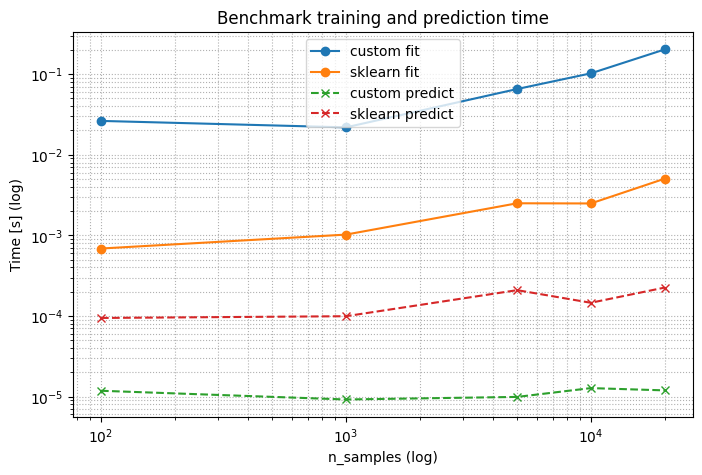

In [24]:
plt.figure(figsize=(8,5))
plt.loglog(df['n_samples'], df['custom_fit'], marker='o', label='custom fit')
plt.loglog(df['n_samples'], df['sklearn_fit'], marker='o', label='sklearn fit')
plt.loglog(df['n_samples'], df['custom_predict'], marker='x', linestyle='--', label='custom predict')
plt.loglog(df['n_samples'], df['sklearn_predict'], marker='x', linestyle='--', label='sklearn predict')
plt.xlabel('n_samples (log)')
plt.ylabel('Time [s] (log)')
plt.title('Benchmark training and prediction time')
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()


### Key Takeaways

- **Training Time**  
  - Both implementations scale roughly linearly in _n_ (O(n)), but scikit-learn is ~30–40× faster thanks to optimized C/BLAS routines.  
- **Prediction Time**  
  - Custom `predict` is ~5–10× faster for a fixed test set, since it uses a single NumPy matrix multiply without extra overhead.  

### 1. Mean Squared Error (MSE)

**Formula:**  
$$
\mathrm{MSE} = \frac{1}{n} \sum_{i=1}^{n} \bigl(y_i - \hat y_i\bigr)^{2}
$$

**What it measures:**  
- The average of the squared differences between true values \(y_i\) and predictions \(\hat y_i\).  
- Emphasizes larger errors due to the squaring operation.

**Key points:**  
- Lower MSE implies predictions are, on average, closer to actual targets.  
- Particularly sensitive to outliers, since large residuals contribute quadratically.  

---

### 2. Root Mean Squared Error (RMSE)

**Formula:**  
$$
\mathrm{RMSE} = \sqrt{\mathrm{MSE}}
$$

**What it measures:**  
- The square root of the average squared error—restores original units of the target.  

**Key points:**  
- Easier to interpret than MSE because it’s in the same scale as \(y\).  
- Still amplifies the impact of large deviations.  

---

### 3. Coefficient of Determination (R²)

**Formula:**  
$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat y_i)^{2}}{\sum_{i=1}^{n}(y_i - \bar y)^{2}}
$$

where \(\bar y\) is the mean of the true values.

**What it measures:**  
- The fraction of variance in the target that the model accounts for.  

**Key points:**  
- Values range from \(-\infty\) (poor) up to 1 (perfect fit).  
- A higher \(R^2\) suggests stronger explanatory power, but it doesn’t guarantee that individual predictions are accurate or that the model generalizes well.  


In [ ]:
from mlfs.metrics import mse as custom_mse, rmse as custom_rmse, r2_score as custom_r2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score as sklearn_r2
from mlfs.preprocessing import train_test_split, standardize


X, y = generate_data(10000)
X_train, X_test, y_train, y_test = train_test_split(X,y)

custom_model = CustomLinearRegression()
custom_model.fit(X_train, y_train, plot_cost=True)
sk_model = SklearnLinearRegression()
sk_model = sk_model.fit(X_train, y_train)

y_pred_custom = custom_model.predict(X_test)
y_pred_sk     = sk_model.predict(X_test)

mse_c = custom_mse(y_test,y_pred_custom)
rmse_c = custom_rmse(y_test, y_pred_custom)
r2_c = custom_r2(y_test, y_pred_custom)

mse_s  = mean_squared_error(y_test, y_pred_sk)
rmse_s = np.sqrt(mse_s) 
r2_s   = sklearn_r2(y_test, y_pred_sk)

df_results = pd.DataFrame({
    'model': ['custom', 'sklearn'],
    'MSE':   [mse_c, mse_s],
    'RMSE':  [rmse_c, rmse_s],
    'R2':    [r2_c, r2_s]
})

display(df_results)


Iteration 0: Cost = 9.561993
Iteration 100: Cost = 1.279344
Iteration 200: Cost = 0.174941
Iteration 300: Cost = 0.027670
Iteration 400: Cost = 0.008030
Iteration 500: Cost = 0.005411
Iteration 600: Cost = 0.005062
Convergence reached at iteration 605


,model,MSE,RMSE,R2
0,custom,0.010135,0.100673,0.999465
1,sklearn,0.010039,0.100195,0.999470
